# Geodemographic python example
This notebook contains the workflow for produceding a geodemographic classification in python using k-means clustering. It follows a simplified process, similar to that described in the [2021 OAC Paper](https://rgs-ibg.onlinelibrary.wiley.com/doi/full/10.1111/geoj.12550).

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from clustergram import Clustergram
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from keplergl import KeplerGl
#set a  random seed for reproducibility
random_seed = 507

#load the input data from a csv file 
# The names of the columns are not important, BUT;
# the first column should be the geography code (e.g., Output Area or Local Authority District),
# which will be used as the DataFrame index.
# The remaining columns should be variables for clustering, provided as fractions or percentages of the table total.
def load_data(filepath):
    input_df = pd.read_csv(filepath, index_col=0)
    
    # Check for missing values
    missing_values = input_df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Warning: {missing_values} missing values found in input data. Missing values will be replaced with 0.")
        input_df.fillna(0, inplace=True)
    
    return input_df

# File path to the dataset
inputdata_filepath = "../input_data/Hybrid_OAC.csv"

# Load the dataset
variable_df = load_data(inputdata_filepath)

#drop "country" column
variable_df = variable_df.drop(columns=['country'])
variable_df = variable_df*100
#round to ints
variable_df = variable_df.round(0).astype(int)
#save to data/example_oacdata.csv
variable_df.to_csv('example_oacdata.csv')
#show first 5 rows of the dataset
variable_df.head()


#limit to OAs in Liverpool region

# --- Step 2: Load OA boundaries (parquet in EPSG:27700) ---
oas = gpd.read_parquet("../input_data/oabounds.parquet")

#set index to "OA"

oas = oas.set_index("OA")
# --- Step 4: Clip to Liverpool bounding box (EPSG:27700) ---
bbox = {
    "minx": 320000,
    "maxx": 350000,
    "miny": 377000,
    "maxy": 407000
}
oas_liv = oas.cx[bbox["minx"]:bbox["maxx"], bbox["miny"]:bbox["maxy"]]

# #keeo only OAs in Liverpool
variable_df=variable_df.loc[variable_df.index.isin(oas_liv.index)]

/home/ogoodwin/projects/GeoDem_CartoWorkshop2025/.venv/lib/python3.12/site-packages/keplergl/keplergl.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
variable_df

,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
Geography_Code,,,,,,,,,,,,,,,,,,,,,
E00032499,0,80,80,73,78,67,76,98,44,0,...,56,61,63,58,68,60,48,81,61,64
E00032500,0,87,66,81,94,52,65,86,86,16,...,55,45,26,53,76,77,63,82,57,74
E00032501,0,83,75,72,87,53,67,99,29,0,...,0,60,71,63,52,67,53,78,56,65
E00032502,0,86,69,76,80,64,78,99,21,21,...,43,55,66,65,53,65,37,79,71,64
E00032504,0,81,79,68,83,47,75,99,45,0,...,47,50,70,60,60,73,41,82,62,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W00001367,0,78,80,74,82,64,71,99,42,0,...,45,69,66,52,67,52,37,86,64,65
W00001583,65,76,84,62,78,75,73,99,38,9,...,50,65,70,43,64,63,25,81,65,71
W00001589,0,76,85,64,80,69,78,99,42,0,...,56,67,58,52,63,65,30,86,70,73


# Explainer of what an OA is.

In [3]:
def transform_and_standardize_data(df):
    """Apply inverse hyperbolic sine transform, to account for non-normality
      and then range standardize using min-max scaling to the dataframe."""
    df = np.arcsinh(df)
    df = (df - df.min()) / (df.max() - df.min())
    return df

# Transform the input data
transformed_variable_df = transform_and_standardize_data(variable_df)


In [4]:
transformed_variable_df

,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
Geography_Code,,,,,,,,,,,,,,,,,,,,,
E00032499,0.000000,0.814633,0.922883,0.947909,0.772049,0.931598,0.961374,0.938500,0.865961,0.000000,...,0.936784,0.958770,0.937442,0.938970,0.967981,0.932188,0.899363,0.894973,0.460515,0.511003
E00032500,0.000000,0.884314,0.841518,0.967687,0.958383,0.883398,0.931459,0.540874,0.995554,0.726659,...,0.933208,0.898068,0.765952,0.921166,0.989894,0.980755,0.952934,0.907204,0.386497,0.677618
E00032501,0.000000,0.845215,0.895586,0.945286,0.881100,0.887020,0.937257,0.969405,0.785365,0.000000,...,0.000000,0.955471,0.960611,0.955302,0.915131,0.953671,0.918883,0.857352,0.367180,0.528796
E00032502,0.000000,0.874710,0.860319,0.955569,0.797332,0.922886,0.966344,0.969405,0.722991,0.783573,...,0.884353,0.938109,0.946458,0.961474,0.918883,0.947771,0.848092,0.870051,0.626194,0.511003
E00032504,0.000000,0.824953,0.917563,0.934415,0.834096,0.864173,0.958839,0.969405,0.870306,0.000000,...,0.902008,0.919091,0.957862,0.945666,0.943322,0.970369,0.868312,0.907204,0.478261,0.511003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W00001367,0.000000,0.793602,0.922883,0.950497,0.821991,0.922886,0.948352,0.969405,0.856966,0.000000,...,0.893377,0.983361,0.946458,0.917404,0.965062,0.904329,0.848092,0.954681,0.512911,0.528796
W00001583,0.920447,0.772025,0.943520,0.916848,0.772049,0.953050,0.953668,0.969405,0.837616,0.606496,...,0.914289,0.971444,0.957862,0.879874,0.956037,0.941687,0.770888,0.894973,0.529832,0.630123
W00001589,0.000000,0.772025,0.948526,0.922886,0.797332,0.937192,0.966344,0.969405,0.856966,0.000000,...,0.936784,0.977491,0.921416,0.917404,0.952934,0.947771,0.806788,0.954681,0.610713,0.662003


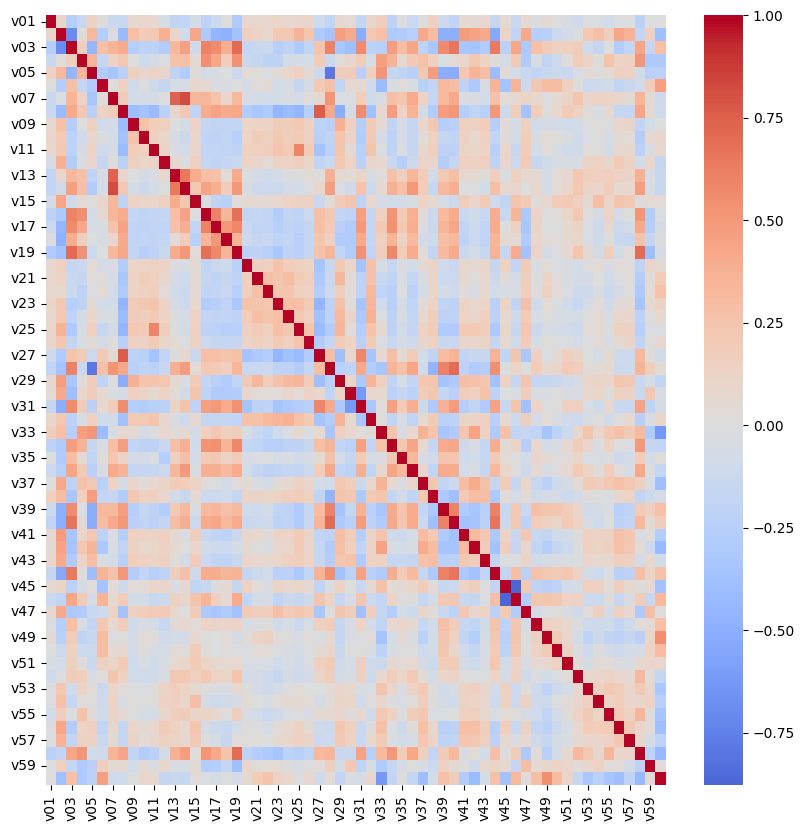

Removed columns: {'v14'}


In [5]:
import seaborn as sns

def check_corrs(df, corr_threshold = 0.9):
    # Compute the correlation matrix
    corr_matrix = df.corr()
    #plot the correlation matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.show()

    # Find the pairs of highly correlated columns
    # Create a mask to exclude the diagonal (correlation of a column with itself)
    highly_corr = np.where((corr_matrix > corr_threshold ) & (corr_matrix != 1))

    # List to keep track of columns to remove
    columns_to_remove = set()
    # Loop through the pairs and add one column to remove for each pair of high correlation
    for i, j in zip(*highly_corr):
        colname_i = corr_matrix.columns[i]
        colname_j = corr_matrix.columns[j]
        # Keep the column that has the most information or less missing data
        if colname_i not in columns_to_remove:
            columns_to_remove.add(colname_j)  # Add the second column of the pair for removal

    # Remove the columns with high correlation
    df_cleaned = df.drop(columns=columns_to_remove)
    # Show the cleaned dataframe
    print(f"Removed columns: {columns_to_remove}")
    return df_cleaned

# Check for highly correlated variables and remove them
cleaned_variable_df = check_corrs(transformed_variable_df, corr_threshold=0.8)

# Clustergrams
We produce a clustergram plot to assess an appropriate number of clusters for the supergroups.
For OAC, eight supergroups were created.
Some guidance on interpreting clustergrams and choosing the number of clusters can be found here:
Clustergram Documentation

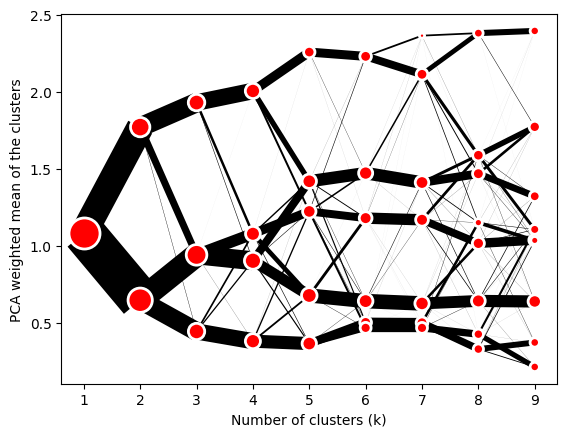

In [6]:

def create_clustergram(df, n_init, save_loc, random_seed=random_seed):
    """
    Create and save a clustergram for evaluating k-means clustering solutions.

    The clustergram visualizes clustering stability and helps identify the optimal 
    number of clusters by performed the k-means algorithm for a range of cluster
    numbers.
    Since k-means is sensitive to initialization, `n_init` determines the number of 
    times the algorithm runs with different centroid seeds. The final result is the 
    best outcome based on inertia/WCSS (within-cluster sum of squares.

    Parameters:
    df (pd.DataFrame or np.ndarray): The input data for clustering.
    n_init (int): Number of k-means runs with different initial centroid seeds. 
                  Higher values (e.g., ~1000) improve solution stability but increase runtime.
    save_loc (str): File path to save the clustergram plot.
    random_seed (int, optional): Random seed for reproducibility.
    """
    cgram = Clustergram(range(1, 10), n_init=n_init, random_state=random_seed,verbose=False)  # Initialize clustergram model
    cgram.fit(df)  # Fit model to data
    cgram.plot()  # Generate plot
    plt.savefig(save_loc)  # Save figure
    plt.show()  # Display plot

# Example usage
n_init = 1  # Use a low value for quick testing, increase (~100) for final results
create_clustergram(cleaned_variable_df, n_init, save_loc="../plots/supergroup_clustergram.png")


In [7]:
def run_kmeans(input_df, num_clusters, n_init, output_filepath, random_seed=None):
    """
    Run K-means clustering on the input dataset and save the cluster assignments.

    This function applies K-means clustering to the provided dataset, assigns cluster 
    labels to each row, and saves the cluster assignments as a lookup table.

    Parameters:
    input_df (pd.DataFrame): The input dataset to be clustered.
    num_clusters (int): The number of clusters (K) to create.
    n_init (int): Number of times the K-means algorithm runs with different initial 
                  centroid seeds. The best result based on inertia/WCSS is chosen. 
                  A higher value (e.g., ~1000) is recommended for final results, 
                  but a lower value can be used for testing.
    output_filepath (str): Path to save the resulting cluster assignments.
    random_seed (int, optional): Random seed for reproducibility.

    Returns:
    pd.DataFrame: The input DataFrame with an added 'cluster' column containing 
                  the assigned cluster for each row.
    """
    df = input_df.copy()
    # Initialize the K-means model
    kmeans_model = KMeans(n_clusters=num_clusters, max_iter=10, random_state=random_seed, n_init=n_init)
    
    # Fit the model and assign clusters
    df['cluster'] = kmeans_model.fit_predict(df)

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)

    # Save the cluster assignments to a CSV file
    df[['cluster']].to_csv(output_filepath)

    # Show the first few rows of the assigned clusters
    print(f"K-means clusters:\n{df[['cluster']].head()}")

    return df

# Define the number of clusters (K). Choose K based on the clustergram plot.
num_clusters = 5
output_filepath = "outputs/supergroups_clusteroutput.csv"

# Run K-means clustering
supergrouped_variable_df = run_kmeans(cleaned_variable_df, num_clusters, n_init=1000, output_filepath = output_filepath, random_seed=random_seed)

# Map numeric labels to letters
label_map = {i: chr(65 + i) for i in range(5)}  # 0->A, 1->B, etc.
supergrouped_variable_df['cluster'] = supergrouped_variable_df['cluster'].map(label_map)

#supregrouped_variable_df contains the cluster assignments for each row in the input data, and the input data itself.
supergrouped_variable_df.head()


K-means clusters:
                cluster
Geography_Code         
E00032499             2
E00032500             2
E00032501             2
E00032502             4
E00032504             2


,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v52,v53,v54,v55,v56,v57,v58,v59,v60,cluster
Geography_Code,,,,,,,,,,,,,,,,,,,,,
E00032499,0.0,0.814633,0.922883,0.947909,0.772049,0.931598,0.961374,0.938500,0.865961,0.000000,...,0.958770,0.937442,0.938970,0.967981,0.932188,0.899363,0.894973,0.460515,0.511003,C
E00032500,0.0,0.884314,0.841518,0.967687,0.958383,0.883398,0.931459,0.540874,0.995554,0.726659,...,0.898068,0.765952,0.921166,0.989894,0.980755,0.952934,0.907204,0.386497,0.677618,C
E00032501,0.0,0.845215,0.895586,0.945286,0.881100,0.887020,0.937257,0.969405,0.785365,0.000000,...,0.955471,0.960611,0.955302,0.915131,0.953671,0.918883,0.857352,0.367180,0.528796,C
E00032502,0.0,0.874710,0.860319,0.955569,0.797332,0.922886,0.966344,0.969405,0.722991,0.783573,...,0.938109,0.946458,0.961474,0.918883,0.947771,0.848092,0.870051,0.626194,0.511003,E
E00032504,0.0,0.824953,0.917563,0.934415,0.834096,0.864173,0.958839,0.969405,0.870306,0.000000,...,0.919091,0.957862,0.945666,0.943322,0.970369,0.868312,0.907204,0.478261,0.511003,C


In [22]:
# Custom cluster colours for 6 clusters
colors = {
    "A": '#8dd3c7',
    "B": '#ffffb3',
    "C": '#bebada',
    "D": '#fb8072',
    "E": '#fdb462'
}

sorted_clusters = sorted(colors.keys())
color_list = [colors[k] for k in sorted_clusters]

# # Ensure cluster column is string for Kepler
# supergrouped_variable_df["cluster"] = supergrouped_variable_df["cluster"].astype(str)
# #append geometry column from oas_liv to supergrouped_variable_df to make a geodataframe
gdf = oas_liv.merge(supergrouped_variable_df, left_index=True, right_index=True, how='left')


# Config for polygons (fill only, no stroke)
config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [],
            "layers": [
                {
                    "id": "clusters_layer",
                    "type": "geojson",   # polygon layer
                    "config": {
                        "dataId": "clusters",
                        "label": "Clusters",
                        'columns': {'geojson': 'geometry'},
                        "color": [130, 154, 227],
                        "highlightColor": [252, 242, 26, 255],
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "thickness": 0,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Custom",
                                "type": "qualitative",
                                "category": "Custom",
                                "colors": color_list
                            },
                            "filled": True
                        },
                        "hidden": False,
                        "textLabel": []
                    },
                    "visualChannels": {
                        "colorField": {"name": "cluster", "type": "string"},
                        "colorScale": "ordinal",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                }
            ],
            "effects": [],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "clusters": [
                            {"name": "cluster", "format": None}
                        ]
                    },
                    "enabled": True
                }
            },
            "layerBlending": "normal"
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 53.39056,
            "longitude": -2.90914,
            "pitch": 0,
            "zoom": 14.08,
            "isSplit": False
        },
        "mapStyle": {
            "styleType": "dark-matter",
            "topLayerGroups": {
                "water": True,
                "building": True
            },
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False
            },
            "mapStyles": {
                "dark-matter": {
                    "id": "dark-matter",
                    "label": "Carto Dark Matter",
                    "url": "https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json"
                }
            }
        }
    }
}

# Show in Kepler
map_with_basemap = KeplerGl(data={"clusters":gdf}, config=config, height=600)
map_with_basemap.save_to_html(file_name="cluster_map.html")



User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to cluster_map.html!


In [24]:
map_with_basemap

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'clusters_layer', '…

# Subgroups
For OAC the supergroup clusters created above are split further into groups and subgroups by applying the above process iteratively. 
Example code for creating the first layer of subclusters (groups) is below

['A' 'B' 'C' 'D' 'E']
A
Cluster: A, 757 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterA.png


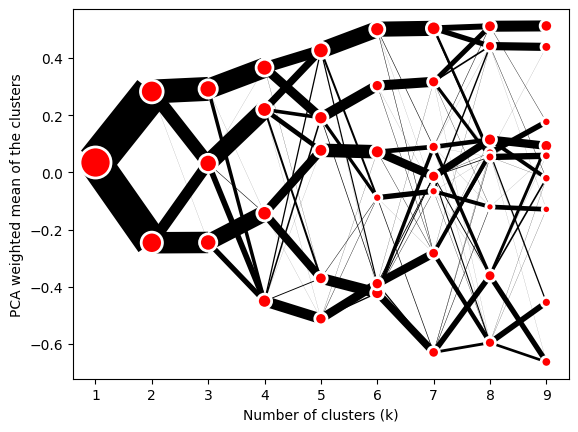

B
Cluster: B, 653 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterB.png


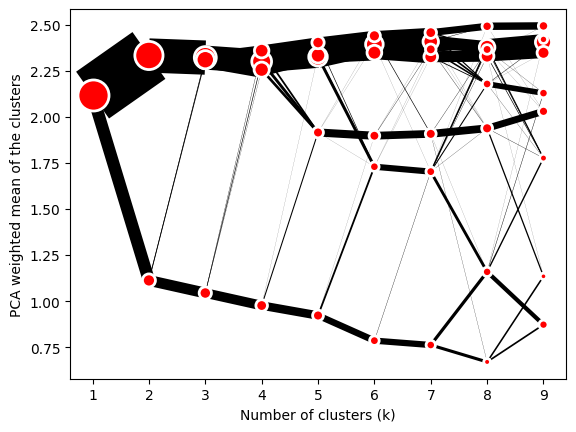

C
Cluster: C, 1024 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterC.png


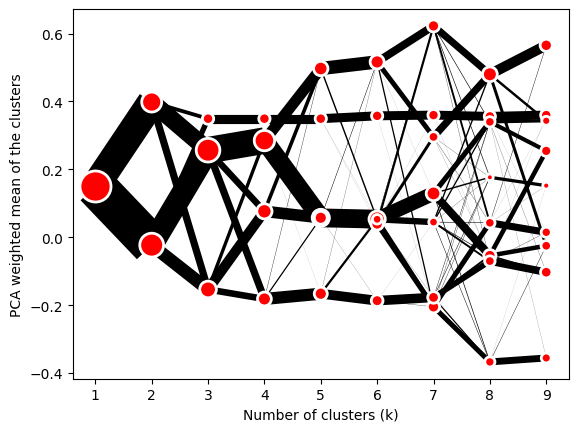

D
Cluster: D, 829 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterD.png


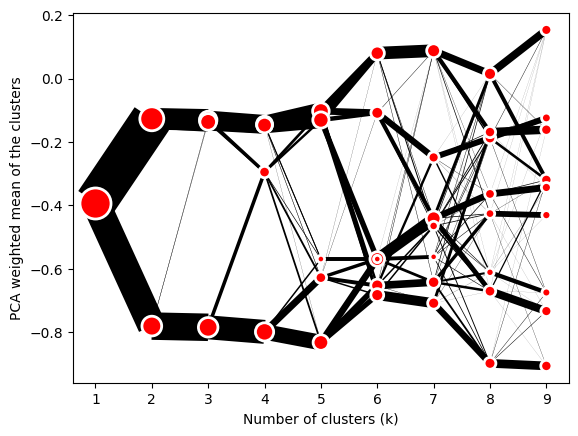

E
Cluster: E, 1061 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterE.png


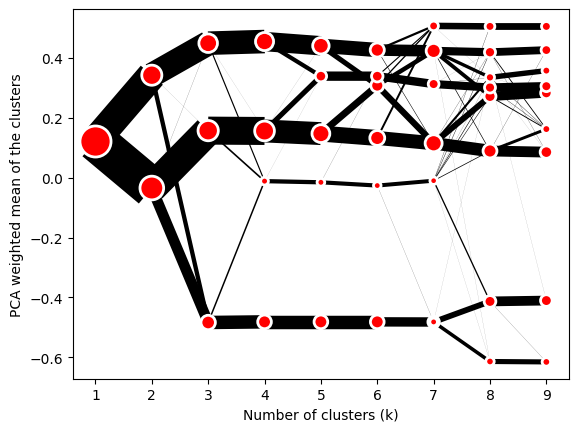

In [32]:
def create_subcluster_clustergrams(output_df, num_clusters, n_init=1):
    """
    Generate and save clustergrams for each supercluster.
    This function loops through the existing clusters and creates a clustergram 
    for each
    Parameters:
    output_df (pd.DataFrame): DataFrame containing cluster assignments.
    num_clusters (int): The total number of clusters to iterate over.
    n_init (int, optional): Number of times K-means runs with different centroid seeds.
                            Defaults to 1 for quick testing.

    """
    save_dir = "plots" #directory to save the clustergrams
    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists
    cluster_labels = np.sort(output_df["cluster"].unique())
    print(cluster_labels)
    for cluster_label in cluster_labels:
        # Select rows corresponding to the current cluster, dropping the 'cluster' column
        print(cluster_label)
        cluster_df = output_df.query("cluster == @cluster_label").drop(columns='cluster')

        print(f"Cluster: {cluster_label}, {len(cluster_df)} geographies in cluster")

        if cluster_df.empty:
            print(f"Skipping cluster {cluster_label} as it has no data.")
            continue

        # Define save location
        save_loc = os.path.join(save_dir, f"subcluster_clustergram_cluster{cluster_label}.png")
        print(f"Saving clustergram to {save_loc}")

        # Generate clustergram
        create_clustergram(cluster_df, n_init=n_init, save_loc=save_loc)

# Example usage
create_subcluster_clustergrams(supergrouped_variable_df, num_clusters, n_init=1)



In [35]:

def run_subclustering(input_df: pd.DataFrame, subcluster_nums: list, num_clusters: int, n_init: int = 1) -> pd.DataFrame:
    """
    Runs subclustering for each supergroup using KMeans and returns a modified DataFrame with subcluster labels.
    
    Parameters:
    - output_df (pd.DataFrame): The original DataFrame containing data and cluster assignments.
    - subcluster_nums (list): A list specifying the number of subclusters to split each supergroup into.
    - num_clusters (int): The total number of supergroups.
    - n_init (int, optional): The number of times KMeans will be initialized. Defaults to 1.

    Returns:
    - pd.DataFrame: A new the output dataFrame with an added 'subcluster' column.
    """

    cluster_labels = np.sort(input_df["cluster"].unique())
    print(f"Cluster labels found: {cluster_labels}")
    if len(subcluster_nums) != len(cluster_labels):
        raise ValueError(f"Length of subcluster_nums ({len(subcluster_nums)}) does not match num_clusters ({len(cluster_labels)}).")

    # Work on a copy of the DataFrame to prevent unintended modifications
    df = input_df.copy()

    for cluster, num_subclusters in zip(cluster_labels, subcluster_nums):
        print(f"Clustering supergroup {cluster} into {num_subclusters} subclusters.")

        # Select rows corresponding to the current cluster, drop the cluster column before clustering
        cluster_df = input_df.query("cluster == @cluster").drop(columns='cluster').copy()
        # Run KMeans clustering for the selected supergroup
        subcluster_output_df = run_kmeans(
            cluster_df, 
            num_subclusters, 
            n_init=n_init, 
            output_filepath=f"outputs/subclusters/supergroup{cluster}_subclusteroutput.csv"
        )

        # Convert subcluster nums 0,1,2,... to a, b, c, ...
        subcluster_output_df['subcluster'] = [str(cluster) + chr(97 + i) for i in subcluster_output_df['cluster']]

        # Update the modified DataFrame with subclustering results
        df.loc[cluster_df.index, 'subcluster'] = subcluster_output_df['subcluster']

    # Save the final output
    df.to_csv("outputs/subgroups_clusteroutput.csv")
    print("Final output saved to outputs/subgroups_clusteroutput.csv")

    return df  # Return the modified DataFrame with clusters and subclusters


#run the subclustering for each of the supergroups
# We can now select the number of subclusters to split each of the supergroups into using the clustergrams above.
# For this example, we choose three subclusters for each supergroup.
# The length of the list must match num_clusters (the number of supergroups).
subcluster_nums = [5, 4, 2, 4, 2]
# subcluster_nums = [2, 4, 2, 2, 5, 2, 3, 3]

subgrouped_variable_df = run_subclustering(supergrouped_variable_df, subcluster_nums, num_clusters=num_clusters, n_init=1)


Cluster labels found: ['A' 'B' 'C' 'D' 'E']
Clustering supergroup A into 5 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032536             1
E00032538             1
E00032541             2
E00032546             4
E00032549             1
Clustering supergroup B into 4 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032537             0
E00032691             3
E00032693             0
E00032735             0
E00032746             0
Clustering supergroup C into 2 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032499             1
E00032500             1
E00032501             0
E00032504             1
E00032506             1
Clustering supergroup D into 4 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032508             3
E00032517             3
E00032520             2
E00032523             2
E00032540             0
Clustering supergroup E into 2 subcl